In [1]:
import os
import sys

# Add the project's root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import random

import numpy as np
import torch

from GP_comp.GP import generate_grids
from SGLD_v7 import SgldBayesianRegression as V7, select_significant_voxels
from models.stgp_neural_network import STGPNeuralNetwork
from simulate_single_modality import simulate_data
from utils import generate_linear_data, plot_mse, plot_sigma_squared, plot_sigma_theta_squared
# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)



In [2]:
in_feature = 6

In [3]:
# Step 2: Generate synthetic data
X, y, true_weights, true_bias = generate_linear_data(n=20000, in_features=in_feature, noise_std=1.0)
print(f"Shape of X: {X.shape}")



Shape of X: torch.Size([20000, 6])


In [4]:
# Step 3: Generate spatial grid
grids = generate_grids(dimensions=1, num_grids=in_feature, grids_lim=(-1, 1))
inputs = torch.ones(in_feature)
expected_y = sum(true_weights) + true_bias

In [5]:
# Step 4: Build model
model = STGPNeuralNetwork(
    in_feature=in_feature,
    grids=grids,
    fully_connected_layers=[3, 5, 1],
    dimensions=1,
)

In [6]:
# Step 5: Train with SGLD
trainer = V7(
    step_size=0.00002,
    num_epochs=300,  # fix this back to 300 later
    burn_in_epochs=0,
    batch_size=1000,
    model=model
)
trainer.train(X, y)

Epoch 1/300
time elapsed 0.0009982585906982422 seconds
Epoch 101/300
time elapsed 22.324501276016235 seconds
Epoch 201/300
time elapsed 45.452065229415894 seconds


In [7]:
print(f"true_weight={true_weights} true_bias={true_bias}")
print(f"X={inputs} Y(predicted)={trainer.predict(inputs, gamma=None)} Y(expected)={expected_y}")

true_weight=tensor([1., 2., 3., 4., 5., 6.]) true_bias=-1.0
predict (sample_avg)::variance_prediction=[4.7476234]
X=tensor([1., 1., 1., 1., 1., 1.]) Y(predicted)=tensor([17.8760]) Y(expected)=20.0


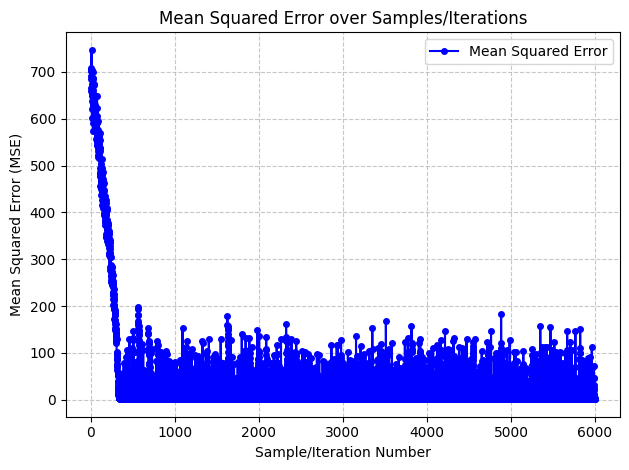

In [8]:
plot_mse(trainer)

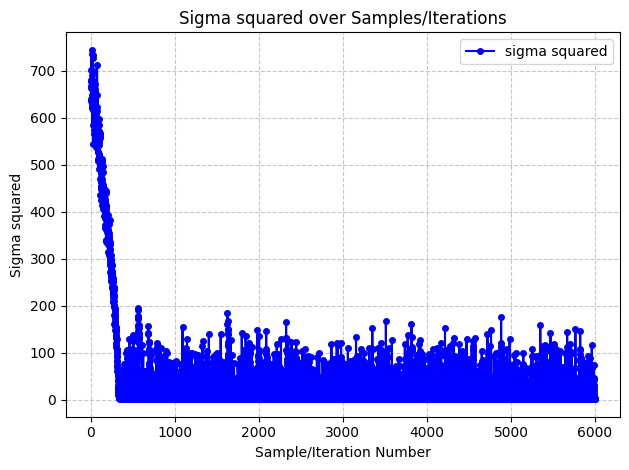

In [9]:
plot_sigma_squared(trainer)

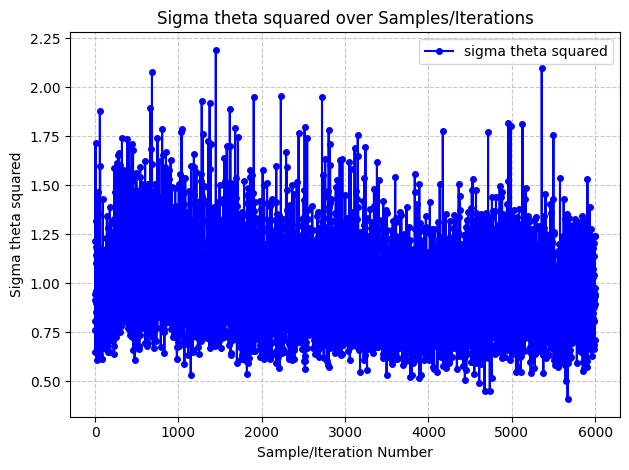

In [10]:
plot_sigma_theta_squared(trainer)

In [11]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 47


In [12]:
print(f"X={inputs} Y(predicted)={trainer.predict(inputs, -1000, -1, gamma=None)} Y(expected)={expected_y}")

predict (sample_avg)::variance_prediction=[3.191536]
X=tensor([1., 1., 1., 1., 1., 1.]) Y(predicted)=tensor([19.0196]) Y(expected)=20.0
